In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lib.assembly_graph
import lib.plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp

In [3]:
def build_from_seed(seed, depth):
    right, left = lib.assembly_graph.build_full_from_seed_graph(seed)
    depth = pd.Series(lib.assembly_graph.add_reverse_complement_depth(depth)).astype(float)
    assert (depth.index.isin(right.keys()) | depth.index.isin(left.keys())).all()
    dgraph = pd.DataFrame(np.zeros((len(depth), len(depth))), index=depth.index, columns=depth.index)
    for unitig in depth.index:
        dgraph.loc[unitig, right[unitig]] = 1
    return dgraph, depth

In [4]:
def initialize_messages(dgraph, depth):
    # Step -1
    send_to_r = dgraph
    send_to_l = dgraph.T
    total_from_l = send_to_r.sum()
    total_from_r = send_to_l.sum()
    send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
    send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T
    send_to_r = send_to_r_next.fillna(0)
    send_to_l = send_to_l_next.fillna(0)

    # Step 0
    total_from_l = send_to_r.sum()
    total_from_r = send_to_l.sum()
    send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
    send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T
    send_to_r = send_to_r_next.fillna(0)
    send_to_l = send_to_l_next.fillna(0)

    return send_to_r, send_to_l

In [82]:
def iterate_messages(send_to_r, send_to_l, depth, gamma=1.0):
    total_from_l = send_to_r.sum()
    total_from_r = send_to_l.sum()
    # Update depth
    next_depth = (total_from_r + total_from_l + (gamma * depth)) / (2 + gamma)
    # Scale the depth so there's no overall loss.
    depth = next_depth * (depth.sum() / next_depth.sum())
    # Calculate next message
    send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
    send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T
    send_to_r = send_to_r_next.fillna(0)
    send_to_l = send_to_l_next.fillna(0)
    return send_to_r, send_to_l, depth

# Tall saw-horse

Converged on iteration 14


<AxesSubplot:>

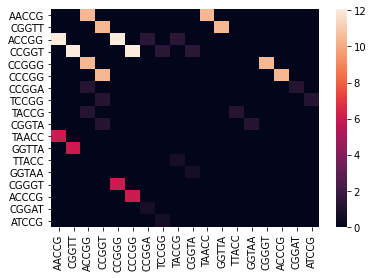

In [92]:
seed = {
    'AACCG': ['ACCGG'],
    'ACCGG': ['CCGGG', 'CCGGA'],
    'TACCG': ['ACCGG'],
    'TAACC': ['AACCG'],
    'TTACC': ['TACCG'],
    'CCGGG': ['CGGGT'],
    'CCGGA': ['CGGAT'],
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'AACCG': 9,
    'ACCGG': 10,
    'CCGGG': 9,
    'CCGGA': 1,
    'TACCG': 1,
    'TAACC': 9,
    'TTACC': 1,
    'CGGGT': 9,
    'CGGAT': 1,
})
dgraph, depth0 = build_from_seed(seed, observed_depth)
send_to_r, send_to_l = initialize_messages(dgraph, depth0)

depth = depth0
thresh = 1e-5
i = 0
while True:
    send_to_r, send_to_l, new_depth = iterate_messages(send_to_r, send_to_l, depth)
    delta = new_depth - depth
    change = np.sqrt(np.sum(np.square(new_depth - depth)))
    depth = new_depth
    if change < thresh:
        print(f"Converged on iteration {i}")
        break
    i += 1
    
sns.heatmap(send_to_r + send_to_l)

# Saw-horse

In [93]:
seed = {
    'AACCG': ['ACCGG'],
    'ACCGG': ['CCGGG', 'CCGGA'],
    'TACCG': ['ACCGG'],
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'AACCG': 3,
    'ACCGG': 4,
    'CCGGG': 3,
    'CCGGA': 1,
    'TACCG': 1,
})
dgraph, depth0 = build_from_seed(seed, observed_depth)
send_to_r, send_to_l = initialize_messages(dgraph, depth0)

depth = depth0
thresh = 1e-5
i = 0
while True:
    send_to_r, send_to_l, new_depth = iterate_messages(send_to_r, send_to_l, depth)
    delta = new_depth - depth
    change = np.sqrt(np.sum(np.square(new_depth - depth)))
    depth = new_depth
    if change < thresh:
        print(f"Converged on iteration {i}")
        break
    i += 1
    
# sns.heatmap(send_to_r + send_to_l)
depth

Converged on iteration 7


AACCG    2.636039
CGGTT    2.636039
ACCGG    4.970562
CCGGT    4.970562
CCGGG    2.636039
CCCGG    2.636039
CCGGA    0.878680
TCCGG    0.878680
TACCG    0.878680
CGGTA    0.878680
dtype: float64

In [ ]:
depth0 = pd.Series(observed_depth).astype(float)
n = len(depth0)
depth0

In [ ]:
# "Directed" graph with each node pointing to nodes that are downstream.
# If I want a graph of each node pointing upstream, that's just dgraph.T
# After the *first* step, where I distribute each nodes depth equally upstream
# and downstream, I'm going to need two contingency tables, because
# uflow != dflow.T

linked_5p_to_3p = downstream

dgraph_5p_to_3p = pd.DataFrame(np.zeros((n, n)), index=depth0.index, columns=depth0.index)
for k in dgraph_5p_to_3p:
    dgraph_5p_to_3p.loc[k, linked_5p_to_3p[k]] = 1

In [ ]:
l_contingency = dgraph_5p_to_3p.copy()
r_contingency = dgraph_5p_to_3p.T.copy()

sns.heatmap(l_contingency)

In [ ]:
# Initialization

send_to_r = r_contingency
send_to_l = l_contingency

# This is not actually the flow,
# because it's not proportional to depth...yet.

depth = depth0

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not initialization
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

# Initialization done
send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [ ]:
# Converge first message

# This is not actually the flow,
# because it's not proportional to depth...yet.

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not initialization
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [ ]:
# One Step
total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# Graveyard of depths past.
# depth = np.sqrt(np.mean((np.array([total_from_r, total_from_l, depth]) + 1)**2))  #  (depth0 * gamma + depth + total_from_r + total_from_l) / (3 + gamma)
# next_depth = np.cbrt((total_from_r + pc) * (total_from_l + pc) * (depth + pc)) - pc
# depth = (
#     np.exp(
#         (
#             np.log(total_from_r + pc) +
#             np.log(total_from_l + pc) +
#             np.log(depth + pc)
#         ) / (3 + pc)
#     )
# )

# Update depth
gamma = 1
next_depth = (total_from_r + total_from_l + (gamma * depth)) / (2 + gamma)
# Scale the depth so there's no overall loss.
depth = next_depth * (depth.sum() / next_depth.sum())

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

# Step done

# sns.heatmap(send_to_r)
# plt.plot(depth)
# plt.ylim(0)
depth

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

# Cycle w/ Switch-back

In [ ]:
seed = {
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGT'],
    'CCGGT': ['CGGTA'],
    'CGGTA': ['GGTAC'],
    'GGTAC': ['GTACC'],
    'GTACC': ['TACCC'],
    'TACCC': ['ACCCG'],
}
downstream, upstream = lib.assembly_graph.build_full_from_seed_graph(seed)

observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGT': 1,
    'CGGTA': 1,
    'GGTAC': 1,
    'GTACC': 1,
    'TACCC': 1,
})

assert lib.assembly_graph.mapping_all_upstream(upstream)
upstream, observed_depth

In [ ]:
depth0 = pd.Series(observed_depth).astype(float)
n = len(depth0)
depth0

In [ ]:
# "Directed" graph with each node pointing to nodes that are downstream.
# If I want a graph of each node pointing upstream, that's just dgraph.T
# After the *first* step, where I distribute each nodes depth equally upstream
# and downstream, I'm going to need two contingency tables, because
# uflow != dflow.T

linked_5p_to_3p = downstream

dgraph_5p_to_3p = pd.DataFrame(np.zeros((n, n)), index=depth0.index, columns=depth0.index)
for k in dgraph_5p_to_3p:
    dgraph_5p_to_3p.loc[k, linked_5p_to_3p[k]] = 1

In [ ]:
l_contingency = dgraph_5p_to_3p.copy()
r_contingency = dgraph_5p_to_3p.T.copy()

sns.heatmap(l_contingency)

In [ ]:
# Initialization

send_to_r = r_contingency
send_to_l = l_contingency

# This is not actually the flow,
# because it's not proportional to depth...yet.

depth = depth0

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not initialization
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

# Initialization done
send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [ ]:
# Converge first message

# This is not actually the flow,
# because it's not proportional to depth...yet.

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not initialization
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [ ]:
# One Step
total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# Graveyard of depths past.
# depth = np.sqrt(np.mean((np.array([total_from_r, total_from_l, depth]) + 1)**2))  #  (depth0 * gamma + depth + total_from_r + total_from_l) / (3 + gamma)
# next_depth = np.cbrt((total_from_r + pc) * (total_from_l + pc) * (depth + pc)) - pc
# depth = (
#     np.exp(
#         (
#             np.log(total_from_r + pc) +
#             np.log(total_from_l + pc) +
#             np.log(depth + pc)
#         ) / (3 + pc)
#     )
# )

# Update depth
gamma = 1
next_depth = (total_from_r + total_from_l + (gamma * depth)) / (2 + gamma)
# Scale the depth so there's no overall loss.
depth = next_depth * (depth.sum() / next_depth.sum())

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

# Step done

# sns.heatmap(send_to_r)
# plt.plot(depth)
# plt.ylim(0)
depth

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

# Six-cycle

In [ ]:
seed = {
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGA'],
    'CCGGA': ['CGGAC'],
    'CGGAC': ['GGACC'],
    'GGACC': ['GACCC'],
    'GACCC': ['ACCCG']
}
downstream, upstream = lib.assembly_graph.build_full_from_seed_graph(seed)

observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGA': 2,
    'CGGAC': 1,
    'GGACC': 1,
    'GACCC': 1,
})

assert lib.assembly_graph.mapping_all_upstream(upstream)
upstream, observed_depth

In [ ]:
depth0 = pd.Series(observed_depth).astype(float)
n = len(depth0)
depth0

In [ ]:
# "Directed" graph with each node pointing to nodes that are downstream.
# If I want a graph of each node pointing upstream, that's just dgraph.T
# After the *first* step, where I distribute each nodes depth equally upstream
# and downstream, I'm going to need two contingency tables, because
# uflow != dflow.T

linked_5p_to_3p = downstream

dgraph_5p_to_3p = pd.DataFrame(np.zeros((n, n)), index=depth0.index, columns=depth0.index)
for k in dgraph_5p_to_3p:
    dgraph_5p_to_3p.loc[k, linked_5p_to_3p[k]] = 1

In [ ]:
l_contingency = dgraph_5p_to_3p.copy()
r_contingency = dgraph_5p_to_3p.T.copy()

sns.heatmap(l_contingency)

In [ ]:
# Initialization

send_to_r = r_contingency
send_to_l = l_contingency

# This is not actually the flow,
# because it's not proportional to depth...yet.

depth = depth0

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not initialization
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

# Initialization done
send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [ ]:
# Converge first message

# This is not actually the flow,
# because it's not proportional to depth...yet.

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not finding the first message
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [ ]:
# One Step
total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# Graveyard of depths past.
# depth = np.sqrt(np.mean((np.array([total_from_r, total_from_l, depth]) + 1)**2))  #  (depth0 * gamma + depth + total_from_r + total_from_l) / (3 + gamma)
# next_depth = np.cbrt((total_from_r + pc) * (total_from_l + pc) * (depth + pc)) - pc
# depth = (
#     np.exp(
#         (
#             np.log(total_from_r + pc) +
#             np.log(total_from_l + pc) +
#             np.log(depth + pc)
#         ) / (3 + pc)
#     )
# )

# Update depth
gamma = 1.0
nu = 0.

next_depth = (total_from_r + total_from_l + (gamma * depth) + (nu * depth0)) / (2 + gamma + nu)
# Scale the depth so there's no overall loss.
depth = next_depth * (depth.sum() / next_depth.sum())

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

# Step done

# sns.heatmap(send_to_r)
# plt.plot(depth)
# plt.ylim(0)
depth

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

# Double-six-cycle

In [ ]:
seed = {
    # Top cycle
    'GGACC': ['GACCC'],
    'GACCC': ['ACCCG'],
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGA'],
    'CCGGA': ['CGGAC'],
    
    # Link
    'CGGAC': ['GGACC', 'GGACT'],
    
    # Bottom cycle
    'GGACT': ['GACTC'],
    'GACTC': ['ACTCG'],
    'ACTCG': ['CTCGG'],
    'CTCGG': ['TCGGA'],
    'TCGGA': ['CGGAC'],
    
}
downstream, upstream = lib.assembly_graph.build_full_from_seed_graph(seed)

observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    # Top cycle
    'GGACC': 1,
    'GACCC': 1,
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGA': 1,
    
    # Link
    'CGGAC': 3,
    
    # Bottom 
    'GGACT': 2, 
    'GACTC': 2,
    'ACTCG': 2,
    'CTCGG': 2,
    'TCGGA': 2,
})

assert lib.assembly_graph.mapping_all_upstream(upstream)
upstream, observed_depth

In [ ]:
depth0 = pd.Series(observed_depth).astype(float)
n = len(depth0)
depth0

In [ ]:
# "Directed" graph with each node pointing to nodes that are downstream.
# If I want a graph of each node pointing upstream, that's just dgraph.T
# After the *first* step, where I distribute each nodes depth equally upstream
# and downstream, I'm going to need two contingency tables, because
# uflow != dflow.T

linked_5p_to_3p = downstream

dgraph_5p_to_3p = pd.DataFrame(np.zeros((n, n)), index=depth0.index, columns=depth0.index)
for k in dgraph_5p_to_3p:
    dgraph_5p_to_3p.loc[k, linked_5p_to_3p[k]] = 1

In [ ]:
l_contingency = dgraph_5p_to_3p.copy()
r_contingency = dgraph_5p_to_3p.T.copy()

sns.heatmap(l_contingency)

In [ ]:
# Initialization

send_to_r = r_contingency
send_to_l = l_contingency

# This is not actually the flow,
# because it's not proportional to depth...yet.

depth = depth0

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not initialization
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

# Initialization done
send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [ ]:
# Converge first message

# This is not actually the flow,
# because it's not proportional to depth...yet.

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not finding the first message
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [ ]:
# One Step
total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# Graveyard of depths past.
# depth = np.sqrt(np.mean((np.array([total_from_r, total_from_l, depth]) + 1)**2))  #  (depth0 * gamma + depth + total_from_r + total_from_l) / (3 + gamma)
# next_depth = np.cbrt((total_from_r + pc) * (total_from_l + pc) * (depth + pc)) - pc
# depth = (
#     np.exp(
#         (
#             np.log(total_from_r + pc) +
#             np.log(total_from_l + pc) +
#             np.log(depth + pc)
#         ) / (3 + pc)
#     )
# )

# Update depth
gamma = 1.0
nu = 0.

next_depth = (total_from_r + total_from_l + (gamma * depth) + (nu * depth0)) / (2 + gamma + nu)
# Scale the depth so there's no overall loss.
depth = next_depth * (depth.sum() / next_depth.sum())

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

# Step done

# sns.heatmap(send_to_r)
# plt.plot(depth)
# plt.ylim(0)
depth

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

# Lonely-stick

In [ ]:
seed = {
    # Top cycle
    'GGACC': [],
}
downstream, upstream = lib.assembly_graph.build_full_from_seed_graph(seed)

observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    # Top cycle
    'GGACC': 1,
})

assert lib.assembly_graph.mapping_all_upstream(upstream)
upstream, observed_depth

In [ ]:
depth0 = pd.Series(observed_depth).astype(float)
n = len(depth0)
depth0

In [ ]:
# "Directed" graph with each node pointing to nodes that are downstream.
# If I want a graph of each node pointing upstream, that's just dgraph.T
# After the *first* step, where I distribute each nodes depth equally upstream
# and downstream, I'm going to need two contingency tables, because
# uflow != dflow.T

linked_5p_to_3p = downstream

dgraph_5p_to_3p = pd.DataFrame(np.zeros((n, n)), index=depth0.index, columns=depth0.index)
for k in dgraph_5p_to_3p:
    dgraph_5p_to_3p.loc[k, linked_5p_to_3p[k]] = 1

In [ ]:
l_contingency = dgraph_5p_to_3p.copy()
r_contingency = dgraph_5p_to_3p.T.copy()

sns.heatmap(l_contingency)

In [ ]:
# Initialization

send_to_r = r_contingency
send_to_l = l_contingency

# This is not actually the flow,
# because it's not proportional to depth...yet.

depth = depth0

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not initialization
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

# Initialization done
send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [ ]:
# Converge first message

# This is not actually the flow,
# because it's not proportional to depth...yet.

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not finding the first message
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [ ]:
# One Step
total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# Graveyard of depths past.
# depth = np.sqrt(np.mean((np.array([total_from_r, total_from_l, depth]) + 1)**2))  #  (depth0 * gamma + depth + total_from_r + total_from_l) / (3 + gamma)
# next_depth = np.cbrt((total_from_r + pc) * (total_from_l + pc) * (depth + pc)) - pc
# depth = (
#     np.exp(
#         (
#             np.log(total_from_r + pc) +
#             np.log(total_from_l + pc) +
#             np.log(depth + pc)
#         ) / (3 + pc)
#     )
# )

# Update depth
gamma = 1.0
nu = 0.

next_depth = (total_from_r + total_from_l + (gamma * depth) + (nu * depth0)) / (2 + gamma + nu)
# Scale the depth so there's no overall loss.
depth = next_depth * (depth.sum() / next_depth.sum())

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

# Step done

# sns.heatmap(send_to_r)
# plt.plot(depth)
# plt.ylim(0)
depth

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table